# 3-Layer HM-LSTM model with protein sequences

### Import packages and activate cuda

In [0]:
import torch, math, time, os
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import glob, sys, csv

from torch.autograd import Variable, Function
from torch.nn import Module, Parameter
from torch.nn.functional import softmax
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings(action='once')

In [2]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


### Small function and class

In [0]:
#A modification of the simoid function, as described in the article. a defines the slope hard_sigm(x) = max(0,min(1,(ax+1)/2))
def hard_sigm(a, x):
    temp = torch.div(torch.add(torch.mul(x, a), 1), 2.0)
    output = torch.clamp(temp, min=0, max=1)
    return output

In [0]:
class bound(Function):
    def forward(self, x):
        # forward : x -> output
        self.save_for_backward(x)
        output = x > 0.5
        return output.float()

    def backward(self, output_grad):
        # backward: output_grad -> x_grad
        x = self.saved_tensors
        x_grad = None

        if self.needs_input_grad[0]:
            x_grad = output_grad.clone()

        return x_grad

## HM_LSTM network defined by 3 classes (CELL, HMLSTM AND HMLSTM NET)

In [0]:
class HM_LSTMCell(Module):
    def __init__(self, bottom_size, hidden_size, top_size, a, last_layer):
        super(HM_LSTMCell, self).__init__()
        self.bottom_size = bottom_size
        self.hidden_size = hidden_size 
        self.top_size = top_size
        self.a = a #se slope annealing trick i training
        self.last_layer = last_layer


        #Initialize weight matrices for transition of hidden states between HM_LSTM cells
        '''
        U_recur means the state transition parameters from layer l (current layer) to layer l
        U_topdown means the state transition parameters from layer l+1 (top layer) to layer l
        W_bottomup means the state transition parameters from layer l-1 (bottom layer) to layer l
        '''
        self.W_bottomup = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.bottom_size))
        self.U_recur = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.hidden_size))

        if not self.last_layer:
            self.U_topdown = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.top_size))

        self.bias = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1))

        #Perform weight initialization of these 4 (or 3) parameters with function defined below.
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for par in self.parameters():
            par.data.uniform_(-stdv, stdv)

    def forward(self, c, h_bottomup, h_recur, h_topdown, z, z_bottom): 
        # h_bottom.size = bottom_size * batch_size
        """
        c:                  cell state in previous cell (l,t-1)
        h_bottomup:         hidden states in layer below (l-1,t)
        h_recur:            hidden states in previous timestep (l,t-1)
        h_topdown:          hidden states in layer above and previous timestep (l+1,t-1)
        z:                  boundary state in previous time step (l,t-1)
        z_bottom:           boundary state in layer below (l-1,t)

        """
        #Calculate s-matrices to calculate new cell state (COPY,UPDATE or FLUSH)
        s_recur = torch.mm(self.U_recur, h_recur)
        
        s_bottomup_init = torch.mm(self.W_bottomup, h_bottomup)
        s_bottomup = z_bottom.expand_as(s_bottomup_init) * s_bottomup_init

        #If not last layer, calculate s_topdown, else set s_topdown to 0
        if not self.last_layer:
            s_topdown_init = torch.mm(self.U_topdown, h_topdown) 
            s_topdown = z.expand_as(s_topdown_init) * s_topdown_init
        else:
            s_topdown = Variable(torch.zeros(s_recur.size()).cuda(), requires_grad=False).cuda()


        #Extract individual variables (matrix/vector) from the large S matrix (f_s: f_slice) 
        f_s = s_recur + s_topdown + s_bottomup + self.bias.unsqueeze(1).expand_as(s_recur)

        # f_s.size = (4 * hidden_size + 1) * batch_size
        f = torch.sigmoid(f_s[0:self.hidden_size, :])  # hidden_size * batch_size
        i = torch.sigmoid(f_s[self.hidden_size:self.hidden_size*2, :])
        o = torch.sigmoid(f_s[self.hidden_size*2:self.hidden_size*3, :])
        g = torch.tanh(f_s[self.hidden_size*3:self.hidden_size*4, :])
        z_hat = hard_sigm(self.a, f_s[self.hidden_size*4:self.hidden_size*4+1, :])

        #Make vector of ones and resize the boundary states (z-values) to be the same size as the cell parameters (f, i, o and g) 
        one = Variable(torch.ones(f.size()).cuda(), requires_grad=False)
        z = z.expand_as(f)
        z_bottom = z_bottom.expand_as(f)

        #Calculate cell state (one line implementation of out commented if/else below)
        c_new = z * (i * g) + (one - z) * (one - z_bottom) * c + (one - z) * z_bottom * (f * c + i * g) #burde ikke beregnes for ethvert tilfælde? 
        h_new = z * o * torch.tanh(c_new) + (one - z) * (one - z_bottom) * h_recur + (one - z) * z_bottom * o * torch.tanh(c_new)

        # if z == 1: (FLUSH)
        #     c_new = i * g
        #     h_new = o * Func.tanh(c_new)
        # elif z_bottom == 0: (COPY)
        #     c_new = c
        #     h_new = h
        # else: (UPDATE)
        #     c_new = f * c + i * g
        #     h_new = o * Func.tanh(c_new)

        #Saves original x values: both 0, 1 and values in between (found using a), to be used in the backward pass. 
        #Hereafter sets x < 0.5 to 0 and x > 0.5 to 1 as they are used in the forward pass
        z_new = bound()(z_hat)

        return h_new, c_new, z_new

In [0]:
class HM_LSTM(Module): #Istedet for at lave egen LSTM så brug den fra main.py
    def __init__(self, a, input_size, size_list):
        super(HM_LSTM, self).__init__()
        self.a = a
        self.input_size = input_size #bottom_size
        self.size_list = size_list 
        
        """
        input_size:        Input size to network
        size_list[0]:      hidden size of layer 1 aka. input size after embedding
        size_list[1]:      hidden size of layer 2
        size_list[2]:      hidden size of layer 3
        """

        #Init cell state
        self.cell_1 = HM_LSTMCell(self.input_size, self.size_list[0], self.size_list[1], self.a, False) #bottom_size, hidden_size, top_size, a, last_layer
        self.cell_2 = HM_LSTMCell(self.size_list[0], self.size_list[1], self.size_list[2], self.a, False)
        self.cell_3 = HM_LSTMCell(self.size_list[1], self.size_list[2], None, self.a, True)

    def forward(self, inputs, hidden): #hidden state supplied, if the model is going to freestyle or make predictions that dont start from 0
        # inputs.size = (batch_size, time steps, embed_size/input_size) 

        time_steps = inputs.size(1)
        batch_size = inputs.size(0)

        if hidden == None:
            #Layer 1
            h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
            c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
            z_t1 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
            #Layer 2
            h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
            c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
            z_t2 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
            #Layer 3
            h_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
            c_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
            z_t3 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        else:
            (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, h_t3, c_t3, z_t3) = hidden

        #Make vector of ones with the same size as batch, so that input is always passed via s_bottomup (see HMLSTMCell)
        z_one = Variable(torch.ones(1, batch_size).float().cuda(), requires_grad=False)
        
        """
        h_t1:     hidden states of layer 1 at previous timestep (updates to current in each iteration)
        h_t2:     hidden states of layer 2 at previous timestep (updates to current timestep in each iteration)
        h_t3:     hidden states of layer 3 --||--
        z_1:      boundary state of layer 1 --||--
        z_2:      boundary state of layer 2 --||--
        z_3:      boundary state of layer 3 --||--
        """

        h_1, h_2, h_3, z_1, z_2, z_3 = [], [], [], [], [], [] 


        for t in range(time_steps):
            h_t1, c_t1, z_t1 = self.cell_1(c=c_t1, h_bottomup=inputs[:,t, :].t(), h_recur=h_t1, h_topdown=h_t2, z=z_t1, z_bottom=z_one) #t1 og t2 is layer1 and layer2 and not time1 and time2
            h_t2, c_t2, z_t2 = self.cell_2(c=c_t2, h_bottomup=h_t1, h_recur=h_t2, h_topdown=h_t3, z=z_t2, z_bottom=z_t1)  
            h_t3, c_t3, z_t3 = self.cell_3(c=c_t3, h_bottomup=h_t2, h_recur=h_t3, h_topdown=None, z=z_t3, z_bottom=z_t2)  

            h_1 += [h_t1.t()]
            h_2 += [h_t2.t()]
            h_3 += [h_t3.t()]
            z_1 += [z_t1.t()]
            z_2 += [z_t2.t()]
            z_3 += [z_t2.t()]

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, h_t3, c_t3, z_t3)
        return torch.stack(h_1, dim=1), torch.stack(h_2, dim=1), torch.stack(h_3, dim=1), torch.stack(z_1, dim=1), torch.stack(z_2, dim=1), torch.stack(z_3, dim=1), hidden


In [0]:
class HM_Net(Module):
    def __init__(self, a, size_list, dict_size, embed_size):
        super(HM_Net, self).__init__()
        self.dict_size = dict_size # Vocab size
        self.size_list = size_list # Number of hidden units in each layer
        self.embed_in = nn.Embedding(dict_size, embed_size) #dict_size, embed_size
        self.HM_LSTM = HM_LSTM(a, embed_size, size_list)
        self.weight = nn.Linear(size_list[0]+size_list[1]+size_list[2],3)
        self.embed_out1 = nn.Linear(size_list[0], dict_size)
        self.embed_out2 = nn.Linear(size_list[1], dict_size)
        self.embed_out3 = nn.Linear(size_list[2], dict_size)
        self.relu = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, inputs, target, hidden):
        # inputs : batch_size * time_steps
  
        #Embedding
        emb = self.embed_in(inputs)  # batch_size * time_steps * embed_size

        #Initialize network and do forward pass
        h_1, h_2, h_3, z_1, z_2, z_3, hidden = self.HM_LSTM(emb, hidden)  # batch_size * time_steps * hidden_size

        h = torch.cat((h_1, h_2, h_3), 2) #Applied as a 3D tensor. 


        #Do FFNN throuch weights g1 and g2 to h_e which acts as predictor of x_(t+1). 
        #h: Dim: batch, seq len,  total units in hidden layer
        g = torch.sigmoid(self.weight(h.view(h.size(0)*h.size(1), h.size(2)))) # This g is not the LSTM g, but the g combining the different hidden states to predict the outputs
        g_1 = g[:, 0:1]  # batch_size * time_steps, 1
        g_2 = g[:, 1:2]
        g_3 = g[:, 2:3]

        h_e1 = g_1.expand(g_1.size(0), self.dict_size)*self.embed_out1(h_1.view(h_1.size(0)*h_1.size(1), h_1.size(2)))  
        h_e2 = g_2.expand(g_2.size(0), self.dict_size)*self.embed_out2(h_2.view(h_2.size(0)*h_2.size(1), h_2.size(2)))
        h_e3 = g_3.expand(g_3.size(0), self.dict_size)*self.embed_out3(h_3.view(h_3.size(0)*h_3.size(1), h_3.size(2)))

        h_e = self.relu(h_e1 + h_e2 + h_e3)  # batch_size*time_steps, hidden_size
        output = h_e

        batch_loss = self.loss(output, target) # Variable(target)

        return batch_loss, hidden, output, z_1, z_2, z_3

    def init_hidden(self, batch_size):
        #Layer 1
        h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
        c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
        z_t1 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        # Layer 2
        h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
        c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
        z_t2 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        # Layer 3
        h_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
        c_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
        z_t3 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, h_t3, c_t3, z_t3 )
        return hidden

### Prepare and load data

In [8]:
#Give access
from google.colab import drive
drive.mount('/content/gdrive')

#Download data in the correct folder 
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
! git clone https://github.com/CharKaae/DeepLearningBiodata.git
os.chdir('/content/gdrive/My Drive/Colab Notebooks/DeepLearningBiodata')

#NOTE If line below is comment out, then Archea data will be downloaded if not bacteria data will be loaded
#%cd DeepLearningBiodata/Bacteria/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
fatal: destination path 'DeepLearningBiodata' already exists and is not an empty directory.


In [0]:
#Prepare files and convert into csv format
csv_files = glob.glob("*.txt")

for file in csv_files:
    csv_input = pd.read_csv(file, header=None, names=['aminoacids'])
    csv_input['aminoacids'] = csv_input['aminoacids'].str.replace(" ","")
    csv_input['aminoacids'] = (csv_input['aminoacids'] + ' ')
    csv_input['target'] = csv_input['aminoacids'].str[1:]   

    a = csv_input['aminoacids'].str.cat(sep='')
    t = csv_input['target'].str.cat(sep='')
    df = pd.DataFrame([[a,t]], columns=list('AT'))
    
    df.to_csv(file+'.csv', index=False)

In [10]:
#Increase size limit for csv files 
csv.field_size_limit(sys.maxsize)

#Tokenizer: splits sentences into char tokens
def tokenize(lines):
    return [line for line in lines]

#Set up fields - text (aminoacids) and target (aminoacids+1)
AMINOACIDS = data.Field(tokenize=tokenize,batch_first=True)
TARGET = data.Field(tokenize=tokenize,batch_first=True)

#Load data 
train_data, test_data, valid_data = data.TabularDataset.splits(path='/content/gdrive/My Drive/Colab Notebooks/DeepLearningBiodata/', format='csv', 
                                                    train='train.txt.csv', validation='valid.txt.csv', test='test.txt.csv', fields=[('text', AMINOACIDS), ('target', TARGET)], skip_header = True)
#Build vocab
AMINOACIDS.build_vocab(train_data) 
TARGET.build_vocab(train_data) 

#Split data into batches and with sequence len 100 for backpropagation through time
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train_data, valid_data, test_data), batch_size=64, bptt_len=100, device="cuda:0")

# print batch information
batch = next(iter(train_iter))
print(batch.text)
print(batch.target)

tensor([[17, 11, 16,  ...,  2,  9, 11],
        [ 6,  8, 16,  ..., 12,  3,  4],
        [ 6, 10,  4,  ..., 14,  2,  8],
        ...,
        [ 9,  2,  6,  ..., 15, 13,  3],
        [ 9,  5, 10,  ..., 12,  2,  5],
        [ 2, 18,  4,  ...,  7,  7,  5]], device='cuda:0')
tensor([[ 6,  8, 16,  ..., 12,  3,  4],
        [ 6, 10,  4,  ..., 14,  2,  8],
        [ 9, 13,  9,  ..., 13, 10,  9],
        ...,
        [ 9,  5, 10,  ..., 12,  2,  5],
        [ 2, 18,  4,  ...,  7,  7,  5],
        [19,  2, 12,  ...,  2, 16,  8]], device='cuda:0')


### Initialization of hyperparameters for training loop

In [0]:
model_params = locals().copy()

train_data = train_iter
val_data = valid_iter
test_data = test_iter
dict_size = len(AMINOACIDS.vocab) # vocab_size 
model_params['dict_size'] = dict_size

# Hyper-parameters
num_epochs = 5

size_list = [256, 252, 256] #s[hidden size of layer 1, hidden size of layer 2, hidden size of layer 3]
embed_size = 128
model = HM_Net(1.0, size_list, dict_size, embed_size) # size_list = Number of hidden units in each layer a = 1.0
model = model.cuda()

#Learning rate, decay, optimizer and grad norm 
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = StepLR(optimizer, step_size=3, gamma=0.80)
start_time = time.time()
clip=1

# Track loss
training_loss, validation_loss = [], []
loss_list = []


### Training loop

start training epoch  1 with learning rate: [0.01]
Starting validation data


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


100 Train
--------annealing slope a to 1.04
Epoch:  1 finished. Time elapsed: 1.6350839614868165 minutes
training loss: 2.9885226558236515
validation loss: 3.2631289672851564
start training epoch  2 with learning rate: [0.01]
Starting validation data
100 Train
--------annealing slope a to 1.08
Epoch:  2 finished. Time elapsed: 3.2052066922187805 minutes
training loss: 2.9523572547763
validation loss: 2.9644646310806273
start training epoch  3 with learning rate: [0.01]
Starting validation data
100 Train
--------annealing slope a to 1.12
Epoch:  3 finished. Time elapsed: 4.775685548782349 minutes
training loss: 2.941900271995395
validation loss: 2.9402441024780273
start training epoch  4 with learning rate: [0.008]
Starting validation data
100 Train
--------annealing slope a to 1.1600000000000001
Epoch:  4 finished. Time elapsed: 6.370959361394246 minutes
training loss: 2.9357461344962026
validation loss: 2.935351963043213
start training epoch  5 with learning rate: [0.008]
Starting val

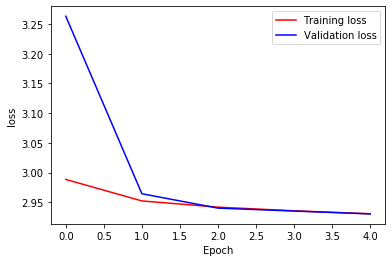

In [17]:
# For each epoch
for epoch in range(num_epochs):
    print("start training epoch ", str(epoch+1), 'with learning rate:', scheduler.get_lr())

    hidden_init = model.init_hidden(batch_size)

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    i = 0
    model.eval()
        
    # For each sentence in validation set
    print('Starting validation data')
    for batch in val_data:
        hidden = hidden_init

        inputs = batch.text
        inputs = inputs.T

        target = batch.target
        target = target.T
        target = target.reshape(-1)
        
        # Forward pass
        loss, hidden, output, z1, z2, z3 = model(inputs, target, hidden)
        
        # Update loss
        epoch_validation_loss += loss.detach().cpu().data.numpy()

    model.train()
    i = 0
    for batch in train_data:
        #For overview print every 100 iterations
        i += 1
        if i%100 == 0:
            print(i,"Train")

        hidden = hidden_init
  
        optimizer.zero_grad()  # 0.0001s used

        inputs = batch.text
        inputs = inputs.T

        target = batch.target
        target = target.T
        target = target.reshape(-1)
              
        loss, hidden, output, z1, z2, z3 = model(inputs, target, hidden) 
        loss.backward() 
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()  # 0.001s used

        # Update loss
        epoch_training_loss += loss.detach().cpu().data.numpy()

    # slope annealing trick
    scheduler.step()
    model.HM_LSTM.cell_1.a += 0.04
    model.HM_LSTM.cell_2.a += 0.04
    print("--------annealing slope a to", model.HM_LSTM.cell_1.a)
    print('Epoch: ', epoch+1, 'finished. Time elapsed:', (time.time() - start_time)/60, 'minutes')
    print('training loss:', epoch_training_loss / len(train_data))
    print('validation loss:', epoch_validation_loss / len(val_data))

    # Save loss for plot
    training_loss.append(epoch_training_loss / len(train_data))
    validation_loss.append(epoch_validation_loss / len(val_data))


# Plot training and validation loss of training and validation batches
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('loss')
plt.show()

### Test loop

In [24]:
# Get first sentence in test set
loss_list = []
BPC_list = []
j=0

for batch in test_data:
    hidden = hidden_init
    inputs = batch.text.T
    target = batch.target.T
    target = target.reshape(-1)

    #Send to network
    loss, hidden, output, z1, z2, z3 = model.forward(inputs, target, hidden)  

    #Track loss
    loss_list.append(loss.detach().cpu().data.numpy())

    target_array = target.cpu().data.numpy()

    #Retrieve data fro correct dim for prediction 
    j += 1
    if j == 18:
        break

print('mean of BPC:', np.mean(loss_list/np.log(2)))

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


mean of BPC: 4.1978703


### Prediction 

In [26]:
# Set up arrays of correct dimensions
z1_array = z1.view(-1, 100*64)
z1_array = z1_array.cpu().data.numpy()

z2_array = z2.view(-1, 64*100)
z2_array = z2_array.cpu().data.numpy()

z3_array = z3.view(-1, 64*100)
z3_array = z3_array.cpu().data.numpy()

l1_state, l2_state, l3_state = 'EMPTY', 'EMPTY', 'EMPTY'

output_array = output.cpu().data.numpy()

for i in range(0,len(output_array),1):
    #predict
    char_vector = output_array[i]
    char = np.argmax(char_vector)
    predict_char = AMINOACIDS.vocab.itos[char]

    # True
    char = target_array[i]
    true_char = AMINOACIDS.vocab.itos[char]

    if i > 0:
      # layer 1
      if z1_array[0, i-1] == 1:
        l1_state = 'FLUSH' # Flush
      else:
        l1_state = 'UPDATE' # update

      # Layer 2
      if z2_array[0, i-1] == 1:
        l2_state = 'FLUSH' # Flush
      elif z2_array[0, i-1] == 0 and z1_array[0, i] == 0:
        l2_state = 'COPY' # Copy
      elif z2_array[0, i-1] == 0 and z1_array[0, i] == 1:
        l2_state = 'UPDATE' # update
      
      # Layer 3
      if z3_array[0, i-1] == 1:
        l3_state = 'FLUSH' # Flush
      elif z3_array[0, i-1] == 0 and z2_array[0, i] == 0:
        l3_state = 'COPY' # Copy
      elif z3_array[0, i-1] == 0 and z2_array[0, i] == 1:
        l3_state = 'UPDATE' # update
    
    print(true_char, predict_char, l1_state, l2_state, l3_state, sep='\t')

A	A	EMPTY	EMPTY	EMPTY
T	L	UPDATE	COPY	COPY
H	I	UPDATE	UPDATE	COPY
E	V	FLUSH	UPDATE	COPY
A	V	FLUSH	UPDATE	COPY
L	L	FLUSH	UPDATE	COPY
Y	E	FLUSH	UPDATE	COPY
T	E	FLUSH	UPDATE	COPY
A	G	FLUSH	UPDATE	COPY
N	G	FLUSH	UPDATE	COPY
D	E	FLUSH	UPDATE	COPY
P	L	FLUSH	UPDATE	COPY
K	V	FLUSH	UPDATE	COPY
Y	V	FLUSH	UPDATE	COPY
G	L	FLUSH	UPDATE	COPY
S	K	FLUSH	UPDATE	COPY
Q	L	FLUSH	UPDATE	COPY
Y	V	FLUSH	UPDATE	COPY
A	L	FLUSH	UPDATE	COPY
P	V	FLUSH	UPDATE	COPY
Q	V	FLUSH	UPDATE	COPY
Q	V	FLUSH	UPDATE	COPY
V	L	FLUSH	UPDATE	COPY
N	A	FLUSH	UPDATE	COPY
A	E	FLUSH	UPDATE	COPY
D	L	FLUSH	UPDATE	COPY
S	V	FLUSH	UPDATE	COPY
A	L	FLUSH	UPDATE	COPY
W	V	FLUSH	UPDATE	COPY
D	A	FLUSH	UPDATE	COPY
T	A	FLUSH	UPDATE	COPY
T	V	FLUSH	UPDATE	COPY
L	G	FLUSH	UPDATE	COPY
G	A	FLUSH	UPDATE	COPY
S	G	FLUSH	UPDATE	COPY
S	G	FLUSH	UPDATE	COPY
S	G	FLUSH	UPDATE	COPY
V	G	FLUSH	UPDATE	COPY
K	A	FLUSH	UPDATE	COPY
I	A	FLUSH	UPDATE	COPY
A	L	FLUSH	UPDATE	COPY
V	E	FLUSH	UPDATE	COPY
V	E	FLUSH	UPDATE	COPY
D	G	FLUSH	UPDATE	COPY
Q	G	FLUSH	UPDATE	COPY
G	L	FLUSH	

### Generation of text

In [30]:
# Convert text to numeric input
input_text = 'new'
input_text = list(input_text)

text_numeric = []

for char in input_text:
  text_numeric.append(AMINOACIDS.vocab.stoi[char])

# Run through model
num_generations = 100
input_array = np.array(text_numeric)

hidden_init = model.init_hidden(1)
hidden = hidden_init

exp_dim = len(input_array)

input_tensor = torch.from_numpy(input_array)
input_tensor = input_tensor.expand(1,exp_dim)
input_tensor = input_tensor.view(exp_dim,-1)
input_tensor = input_tensor.T
input_tensor = input_tensor.cuda()

target_tensor = torch.ones(exp_dim).long().cuda()
loss, hidden, outputs, z1, z2, z3 = model.forward(input_tensor,target_tensor, hidden)

values, indices = outputs[-1].max(0)

input_array = np.append(input_array, indices.cpu().numpy())

for i in range(num_generations):
  hidden_init = model.init_hidden(1)
  hidden = hidden_init
  exp_dim = len(input_array)
  input_tensor = torch.from_numpy(input_array)
  input_tensor = input_tensor.expand(1,exp_dim)
  input_tensor = input_tensor.view(exp_dim,-1)
  input_tensor = input_tensor.T
  input_tensor = input_tensor.cuda()
  target_tensor = torch.ones(exp_dim).long().cuda()
  loss, hidden, outputs, z1, z2, z3 = model.forward(input_tensor,target_tensor, hidden)

  values, indices = outputs[-1].max(0)

  input_array = np.append(input_array, indices.cpu().numpy())

  predicted_sentence = list() 
  
for char in input_array:
  predict_char = AMINOACIDS.vocab.itos[char]
  predicted_sentence.append(predict_char)

print('Predicted sentence:')
print(''.join(predicted_sentence))

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Predicted setence:
<unk><unk><unk>IVVGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
